In [ ]:
#pip install requirements.txt -qq

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date
import seaborn as sns
import shutil
import warnings
warnings.filterwarnings("ignore")
import logging
from tqdm import tqdm

# model
from darts import TimeSeries


In [2]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True)



In [3]:
# save the dataframe for the models
df_el.to_csv('df_clean.csv', index = False)

## EDA

In [4]:
df_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3480 non-null   object
 1   price   3480 non-null   object
dtypes: object(2)
memory usage: 54.5+ KB


In [5]:
df_el.tail()

,date,price
3475,25.05.2023 19:00,59.87
3476,25.05.2023 20:00,64.57
3477,25.05.2023 21:00,106.08
3478,25.05.2023 22:00,65.41
3479,25.05.2023 23:00,59.32


In [6]:
df_el[['day', 'month', 'year']] = df_el['date'].str.split('.', expand=True)

In [7]:
df_el[['year', 'hour']] = df_el['year'].str.split(' ', expand=True)

In [8]:
df_el['time'] = df_el['hour'].apply(lambda x: x[0:2])

In [10]:
# drop date column
df_el.drop(df_el[['hour', 'date']],axis=1, inplace = True)

In [11]:
df_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   3480 non-null   object
 1   day     3480 non-null   object
 2   month   3480 non-null   object
 3   year    3480 non-null   object
 4   time    3480 non-null   object
dtypes: object(5)
memory usage: 136.1+ KB


In [12]:
df_el['price'] = df_el['price'].astype(float)
df_el['year'] = df_el['year'].astype(int)
df_el['month'] = df_el['month'].astype(int)
df_el['day'] = df_el['day'].astype(int)
df_el['time'] = df_el['time'].astype(int)

<AxesSubplot:xlabel='month', ylabel='price'>

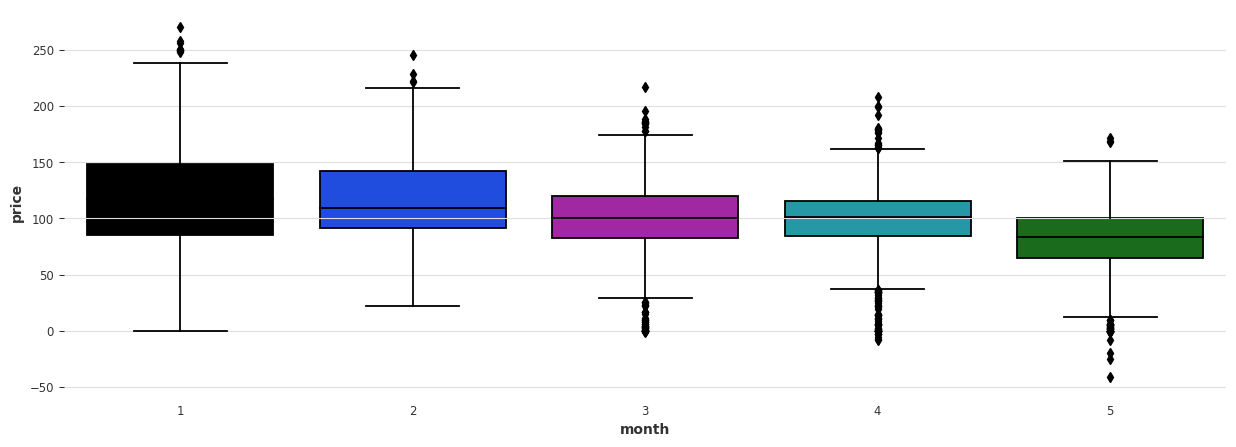

In [13]:
#monthly
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='month', y='price')

<AxesSubplot:xlabel='day', ylabel='price'>

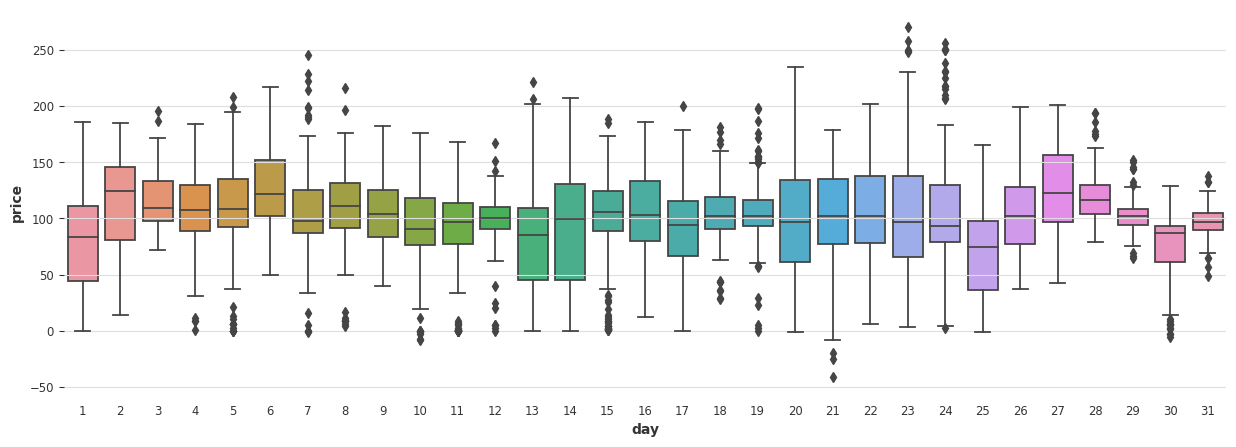

In [14]:
#daily
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='day', y='price')

<AxesSubplot:xlabel='time', ylabel='price'>

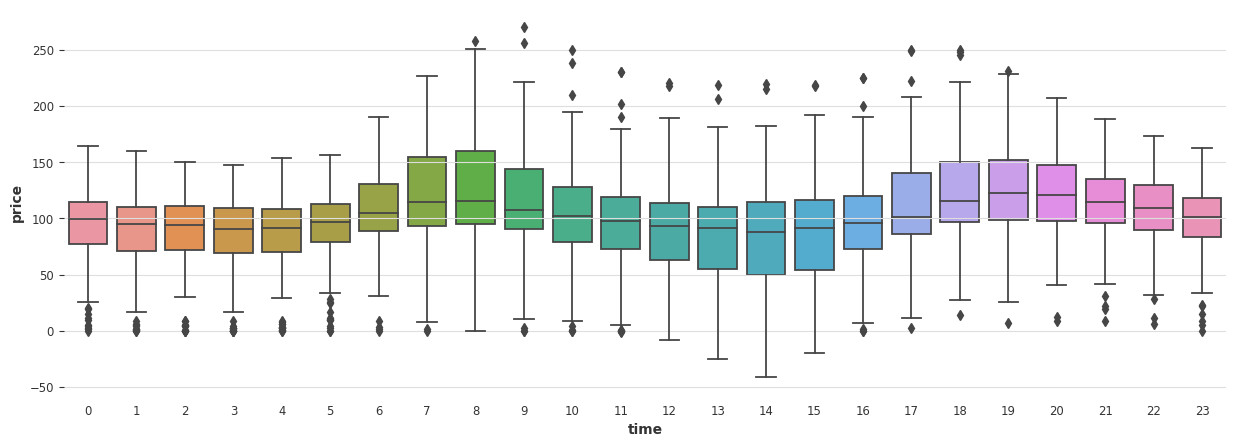

In [15]:
#hourly
plt.figure(figsize=(15,5))
sns.boxplot(data=df_el, x='time', y='price')

# Darts

In [18]:
data = pd.read_csv('df_clean.csv')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3480 non-null   object 
 1   price   3480 non-null   float64
dtypes: float64(1), object(1)
memory usage: 54.5+ KB


In [21]:
# changing the datatype 
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y %H:%M')
ts = TimeSeries.from_dataframe(data, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')


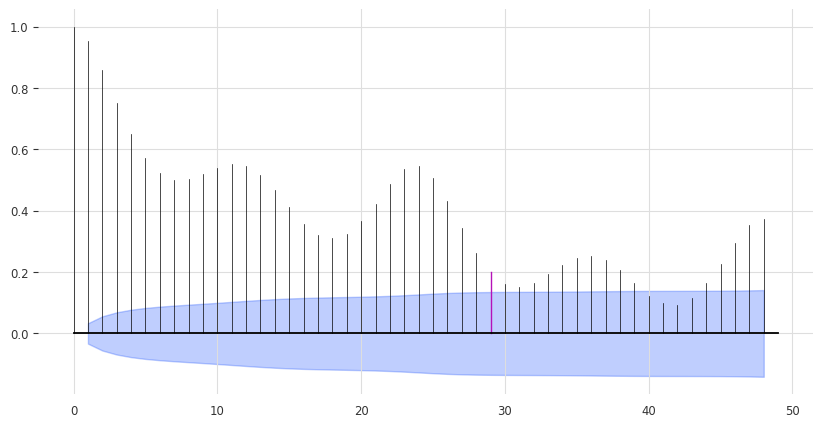

In [22]:
#checking sesonality 
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(ts, m=29, max_lag=48)

In [24]:
check_seasonality(ts, m=24, max_lag=48)

# "max lag" refers to the maximum number of time steps or periods that you want to consider when analyzing the relationship between data points in a time series. It represents the farthest point in the past that you believe may have an impact on the current value of the series.

# For example, if you are analyzing daily temperature data and you set the max lag to 7, it means you are considering the temperature values of the past seven days to potentially influence the current day's temperature.

# In our case, we have hourly prices which we belive might be impacted from last days value as well. So, we will be using 48 as our max lag. 


# "m" refers to the seasonality period or the length of a seasonal cycle within the data. It represents the number of time steps or periods required for the series to repeat its pattern. In our case the prices might repeat every 24 hours, so we have m set to 24.

(True, 24)